# Last-mile Delivery Scheduling and Rescheduling
### Weixuan Yang, Qin Deng, Hanyu Xi
##### The Edward S. Rogers Sr. Department of Electrical & Computer Engineering, University of Toronto
#####{weixuan.yang, davy.deng, hanyuxi}@mail.utoronto.ca

Import libraries

In [5]:
import os
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

Read dataset

In [6]:
raw_data = pd.read_csv('DLA7_package_data.csv', index_col=[0])
package_data = pd.DataFrame(columns=['loc_lat','loc_lng','dim_depth_cm','dim_height_cm','dim_width_cm','tim_start','tim_end','tim_plan_sec'])
loc_data = pd.read_csv('DLA7_stop_data.csv', index_col=[0])
time_data = pd.read_csv('DLA7_travel_data.csv', index_col=[0])
for index, row in raw_data.iterrows():
#     print(index)
    if index not in loc_data.index:
        continue
    for column in row[row.notna()]:
        if column == "{}":
            continue
        column = json.loads(column.replace("'", '"').replace("nan",'"nan"'))
        for id in column.keys():
            package = pd.DataFrame(data=[{"label": index,
                    'loc_lat': loc_data.loc[index,'lat'],
                    'loc_lng': loc_data.loc[index,'lng'],
                    'dim_depth_cm': column[id]['dimensions']['depth_cm'],
                    'dim_height_cm': column[id]['dimensions']['height_cm'],
                    'dim_width_cm': column[id]['dimensions']['width_cm'],
                    'volume': column[id]['dimensions']['depth_cm']*column[id]['dimensions']['height_cm']*column[id]['dimensions']['width_cm'],
                    'tim_start': column[id]['time_window']['start_time_utc'],
                    'tim_end': column[id]['time_window']['end_time_utc'],
                    'tim_plan_sec': column[id]['planned_service_time_seconds']}], index=[id.replace('PackageID_','')])
        package_data = package_data.append(package)
package_data.index.name = 'id'

C:\Users\DengQin\AppData\Local\Temp\ipykernel_15040\909080516.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  package_data = package_data.append(package)
C:\Users\DengQin\AppData\Local\Temp\ipykernel_15040\909080516.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  package_data = package_data.append(package)
C:\Users\DengQin\AppData\Local\Temp\ipykernel_15040\909080516.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  package_data = package_data.append(package)
C:\Users\DengQin\AppData\Local\Temp\ipykernel_15040\909080516.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  package_data = package_data.append(package)
C:\Users

In [7]:
package_data.head()

,loc_lat,loc_lng,dim_depth_cm,dim_height_cm,dim_width_cm,tim_start,tim_end,tim_plan_sec,label,volume
id,,,,,,,,,,
b4602d93-e3e0-4aab-909a-bed9b8829850,33.785869,-117.802461,49.5,7.6,35.6,nan,nan,49.0,AU,13392.720
1f3eb06c-1dd1-4a4e-912d-b334b2504f61,33.786393,-117.825913,34.3,11.4,20.3,nan,nan,59.0,AV,7937.706
e9a647b0-0194-4a31-9110-0ad4e324cefb,33.784522,-117.816622,43.2,7.6,27.9,nan,nan,90.0,AY,9160.128
3114e839-d0d0-417f-8016-8a80bd96a3fa,33.788544,-117.827046,25.4,12.7,17.8,2018-07-26 16:00:00,2018-07-26 23:00:00,430.0,CM,5741.924
16a25f79-40fe-470d-b54a-c53caca0b955,33.784569,-117.817442,31.0,2.0,28.4,nan,nan,52.0,FQ,1760.800


In [8]:
package_data.shape[0]

157

The function returns the travel time between two points

In [9]:
def get_travel_time(a, b):
  """Get the travel time between two points

    Args:
      a (str): the code for the first point
      b (str): the code for the second point

    Returns:
      float: the travel time between the two points
  """
  try:
    travel_time = time_data.loc[a, b]
  except:
    travel_time = time_data.loc[b, a]
  if pd.isna(travel_time):
    raise ValueError('Starting point and destination pair does not exist.')
  return travel_time

In [10]:
get_travel_time("FJ", "AG")

2214.1

# Draw depot and dropoff location

In [13]:
import osmnx
import folium

depot = [33.965477, -117.653303] # DLA7 amazon warehouse
map = folium.Map(location=depot, zoom_start=11)

locations = package_data[['loc_lat', 'loc_lng']]
locationlist = locations.values.tolist()

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(map)
folium.Marker(depot, icon=folium.Icon(color="red", icon="info-sign")).add_to(map)
map


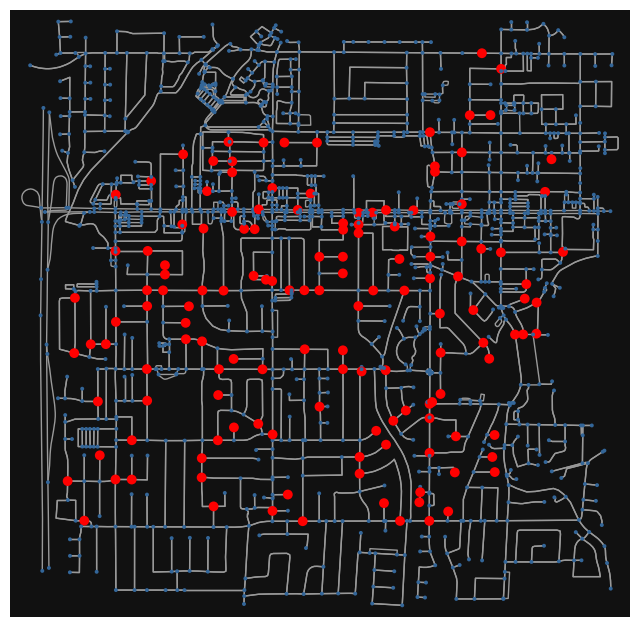

In [14]:
import geopandas

# Choose collection place with index 2 and dropofflist with index 21, 25
X = [l[0] for l in locationlist]
Y = [l[1] for l in locationlist]

center = (sum(X)/len(X), sum(Y)/len(X))
# Get the graph
graph = osmnx.graph_from_point(center, dist=1500)

nodes, edges = osmnx.graph_to_gdfs(graph)
closest_nodes = osmnx.distance.nearest_nodes(graph,Y,X)

# marking both the source and destination node

nc = ['red' if node in closest_nodes else '#336699' for node in graph.nodes()]
ns = [50 if node in closest_nodes else 8 for node in graph.nodes()]
fig, ax = osmnx.plot_graph(graph, node_size=ns, node_color=nc, node_zorder=2)


# Processing function (list2routes, fitness)

In [20]:
# this function is to transform a list of customer/package id to several routes that meet the capacity limit and time window
def ind2route(individual, vehicle_capacity, work_time, package_data, depot):
    # individual: a list of customer id
    # vehicle_capacity: real capacity * 0.6 (cm3)
    # work_time: work_hours
    # package_data: package info dataframe
    # depot: code of station eg:"FJ"
    
    route = []
    
    # Initialize a sub-route
    sub_route = []
    vehicle_load = 0
    elapsed_time = 0
    last_customer_id = -1
    for customer_id in individual:
        # Update vehicle load
        demand = package_data.iloc[customer_id].volume
        updated_vehicle_load = vehicle_load + demand
        # Update elapsed time
        service_time = package_data.iloc[customer_id].tim_plan_sec
        return_time = get_travel_time(package_data.iloc[customer_id].label, depot)
        
        if last_customer_id != -1:
            updated_elapsed_time = elapsed_time + \
                 get_travel_time(package_data.iloc[last_customer_id].label, package_data.iloc[customer_id].label)+ service_time
        else:
            updated_elapsed_time = get_travel_time(depot, package_data.iloc[customer_id].label) + service_time + return_time
        # Validate vehicle load and elapsed time
        if (updated_vehicle_load <= vehicle_capacity) and (updated_elapsed_time <= work_time):
            # Add to current sub-route
            sub_route.append(customer_id)
            vehicle_load = updated_vehicle_load
            elapsed_time = updated_elapsed_time-return_time
        else:
            # Save current sub-route
            route.append(sub_route)
            # Initialize a new sub-route and add to it
            sub_route = [customer_id]
            vehicle_load = demand
            elapsed_time = service_time
        # Update last customer ID
        last_customer_id = customer_id
    if sub_route != []:
        # Save current sub-route before return if not empty
        route.append(sub_route)
    return route

In [21]:
# compute the fitness value
def eval_vrptw(individual, vehicle_capacity, work_time, package_data, unit_cost=1.0, wait_cost=0, delay_cost=0, depot="FJ"):
    # individual: a list of customer id
    # vehicle_capacity: real capacity * 0.6 (cm3)
    # work_time: work_hours(seconds)
    # package_data: package info dataframe
    # depot: code of station eg:"FJ"
    
    total_cost = 0
    route = ind2route(individual, vehicle_capacity, work_time, package_data, depot)
    total_cost = 0
    for sub_route in route:
        sub_route_time_cost = 0
        sub_route_distance = get_travel_time(depot, package_data.iloc[sub_route[0]].label)+\
                                get_travel_time(package_data.iloc[sub_route[-1]].label, depot)
        elapsed_time = get_travel_time(depot, package_data.iloc[sub_route[0]].label)
        last_customer_id = -1
        for customer_id in sub_route:
            # Calculate section distance
            if last_customer_id==-1:
                distance = 0 
            else:
                distance = get_travel_time(package_data.iloc[last_customer_id].label, package_data.iloc[customer_id].label)
            # Update sub-route distance
            sub_route_distance = sub_route_distance + distance
            # Calculate time cost
            arrival_time = elapsed_time + distance
            if package_data.iloc[last_customer_id].tim_start=="nan":
                time_cost=0
            else:
                start = package_data.iloc[last_customer_id].tim_start
                start = start.split()[1]
                start = max((int(start.split(":")[0])-16)*60*60, 0)
                end = package_data.iloc[last_customer_id].tim_end
                end = end.split()[1]
                end = (int(end.split(":")[0])-16)*60*60
                time_cost = wait_cost * max(start - arrival_time, 0) + delay_cost * max(arrival_time - end, 0)
            # Update sub-route time cost
            sub_route_time_cost = sub_route_time_cost + time_cost
            # Update elapsed time
            elapsed_time = arrival_time + package_data.iloc[last_customer_id].tim_plan_sec
            # Update last customer ID
            last_customer_id = customer_id
        # Calculate transport cost
        sub_route_transport_cost = unit_cost * sub_route_distance
        
        # Obtain sub-route cost
        sub_route_cost = sub_route_time_cost + sub_route_transport_cost
        
        # Update total cost
        total_cost = total_cost + sub_route_cost
        
        # modify the wait_cost, delay_cost, unit cost parameters
        #print(sub_route_distance, sub_route_time_cost)
        
    fitness = 1.0 / total_cost
    return fitness

# Genetic algorithm

In [42]:
# mutation and crossover use methods in smart_mobility_utilities.problem
from smart_mobility_utilities.common import random_tour
from smart_mobility_utilities.problem import PMX_crossover, insert_mutation
from tqdm.notebook import tqdm

crossover = PMX_crossover
mutate = insert_mutation

size_of_population = 100
ngen = 500
best_at_gen = [] # for keeping track of the best tour at a given generation

# Initialize population
pool = [*random_tour(range(package_data.shape[0]), number_of_perms=size_of_population)] 


unit_cost = 8.0
wait_cost = 0.5
delay_cost = 1.5

vehicle_capacity = 3313071*0.6*0.2
work_time = 3*60*60
depot="FJ"

mut_prob = 0.3
cro_prob = 0.7

In [43]:
import random

for generation in tqdm(range(ngen)):
    # 1- crossover every consecutive pair of routes
    # 2- replace the weakest of the two parent with the product of the crossover
    # 3- mutate the whole pool
    # 4- repeat and save the value best tour in that generation
    
    # 1-
    for parent1, parent2 in zip(pool, pool[1:]):
        child = crossover(parent1, parent2)
        
        # 2-
        if eval_vrptw(parent1, vehicle_capacity, work_time, package_data, unit_cost, wait_cost, delay_cost, depot) \
            > eval_vrptw(parent2, vehicle_capacity, work_time, package_data, unit_cost, wait_cost, delay_cost, depot):
            pool[pool.index(parent2)] = child
        else:
            pool[pool.index(parent1)] = child
    
    # 3-
    for i in range(size_of_population):
        if random.random() < mut_prob:
            pool[i] = mutate(pool[i])
    
    # 4-
    fitness = []
    for i in range(size_of_population):
        fitness.append(eval_vrptw(pool[i], vehicle_capacity, work_time, package_data, unit_cost, wait_cost, delay_cost))
    best_at_gen.append(max(fitness))
    
    

  0%|          | 0/500 [00:00<?, ?it/s]

In [45]:
tour = max(pool, key = lambda route: eval_vrptw(route, vehicle_capacity, work_time, package_data, unit_cost, 
                                                wait_cost, delay_cost, depot))

print("cost: ")
print(1/eval_vrptw(tour, vehicle_capacity, work_time, package_data, unit_cost, 
                                                wait_cost, delay_cost, depot))
tour = ind2route(tour, vehicle_capacity, work_time, package_data, depot)

print(tour)

cost: 
426241.5999999999
[[127, 115, 79, 35, 93, 103, 140, 19, 4, 10, 148, 46, 110, 126, 7, 45, 152, 120, 72, 70, 22, 39, 55, 12, 41, 104, 24, 67, 150, 26], [80, 62, 25, 121, 51, 0, 36, 83, 64, 5, 102, 44, 124, 135, 29, 118, 142, 156, 106, 82, 101, 61, 95, 92, 134, 69], [71, 13, 78, 37, 40, 108, 153, 48, 137, 43, 75, 84, 131, 154, 107, 52, 91, 60, 3, 27, 116, 88, 143, 123, 34, 9, 99, 76, 122, 147], [149, 117, 111, 14, 2, 58, 28, 85, 130, 17, 98, 66, 89, 141, 145, 54, 87, 151, 33, 128, 15, 144, 56, 139, 90, 105, 133, 138, 16, 57, 97, 38, 8, 53, 21, 49, 23, 155, 96, 136, 77, 109, 129, 30, 63], [47, 132, 20, 86, 18, 73, 119, 50, 125, 11, 113, 81, 1, 65, 32, 100, 74, 94, 6, 42, 112, 146, 114, 59, 31, 68]]


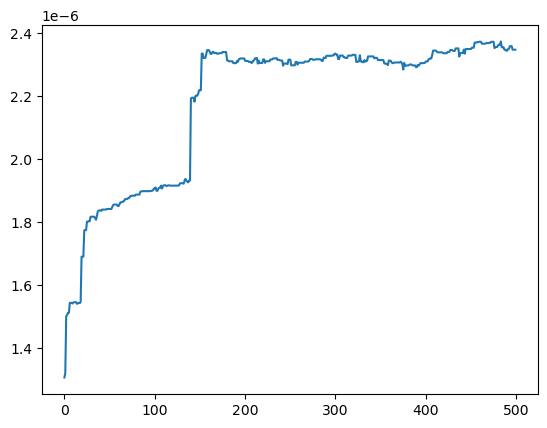

In [46]:
plt.plot(best_at_gen)  

# Draw routes

In [40]:
import networkx

tour = ind2route(pool[0], vehicle_capacity, work_time, package_data, depot)
print(tour)
route = tour[0]

shortest_route = []

for i in range(1, len(route)):
    X = [locationlist[route[i-1]][0], locationlist[route[i]][0]]
    Y = [locationlist[route[i-1]][1], locationlist[route[i]][1]]
    closest_nodes = osmnx.distance.nearest_nodes(graph,Y,X)
    if shortest_route:
        shortest_route = shortest_route[:-1]
    shortest_route.extend(networkx.shortest_path(G=graph,source=closest_nodes[0],target=closest_nodes[1], weight='length'))
    
    
# print(shortest_route)

[[61, 6, 91, 21, 153, 89, 39, 99, 144, 116, 76, 34, 71, 32, 156, 72, 26, 127, 38, 45, 126, 12, 93, 130, 3, 139, 44, 10, 115, 55, 40, 97, 52, 132, 122, 121, 56, 133, 96, 88, 25, 137, 75, 86, 31, 37, 16, 20, 30, 11, 104, 138, 14, 7, 64, 51, 66, 108, 143, 142, 128, 106, 82, 111, 87, 78, 70, 129, 50, 105, 123, 35, 68, 107, 140, 42, 36, 60, 124, 145, 109, 136, 98, 154, 62, 13, 84, 90], [41, 92, 18, 155, 102, 22, 101, 94, 54, 59, 119, 19, 33, 110, 83, 67, 151, 17, 69, 114, 150, 53, 8, 134, 74, 95, 23, 0, 29, 85, 79, 81, 9, 148, 28, 117, 43, 57, 152, 15, 2, 5, 149, 120, 73, 118, 4, 46, 100, 112, 1, 125, 141, 65, 63, 49, 27, 147, 77, 47, 146, 135, 113, 80, 131, 58, 48, 103, 24]]


In [ ]:
import ipyleaflet as lf
from smart_mobility_utilities.viz import draw_route, draw_map

map_dijks = draw_route(graph, shortest_route, force_leaflet=True)
for i in range(1, len(route)-1):
    marker = lf.Marker(location = locationlist[route[i]], draggable = False)
    map_dijks.add_layer(marker)
map_dijks